In [1]:
%load_ext autoreload
%autoreload 2
from individual_channel_gradcam import GradCAM
import os
import cv2 
import pandas as pd
from model import EfficientnetWithFinetuning
from data import MelanomaData
import os
import matplotlib.pyplot as plt
import torch as t
import numpy as np
import seaborn as sns

In [2]:
from captum.attr import GuidedGradCam

/data/bionets/je30bery/anaconda3/envs/als_analysis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [52]:
data = "/data_nfs/datasets/melc/melanoma/processed"

In [27]:
markers = ['ADAM10', 'Bcl-2', 'CD10', 'CD107a', 'CD13', 'CD138', 'CD14', 'CD1a', 'CD2', 'CD25', 'CD271', 'CD3', 'CD36', 'CD4', 'CD44', 'CD45', 'CD45RA', 'CD45RO', 'CD5', 'CD56', 'CD6', 'CD63', 'CD66abce', 'CD7', 'CD71', 'CD8', 'CD9', 'CD95', 'Collagen IV', 'Cytokeratin-14', 'EBF-P', 'EGFR', 'EGFR-AF488', 'HLA-ABC', 'HLA-DR', 'KIP1', 'Ki67', 'L302', 'MCSP', 'Melan-A', 'Nestin-AF488', 'Notch-1', 'Notch-3', 'PPARgamma', 'PPB', 'RIM3', 'TAP73', 'Vimentin', 'p63', 'phospho-Connexin']    

In [28]:
model = EfficientnetWithFinetuning(indim=len(markers))
model.load_state_dict(t.load("/data_nfs/je30bery/melanoma_data/model/saved_models/model_2023-11-20 16:27:56.558630_f1=0.9260606060606061_acc=0.9166666666666666_11.pt"))
for l in model.features:
    l.requires_grad = True
model.eval()

EfficientnetWithFinetuning(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(50, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): 

In [73]:
ggc = GuidedGradCam(model.cuda(), model._modules["features"][0], 0)

In [74]:
vdata = sorted([os.path.join(data, "validation", d) for d in os.listdir(os.path.join(data, "validation"))]) #+ [os.path.join(data, "training", d) for d in sorted(os.listdir(os.path.join(data, "training")))]) # balance_and_shuffle(os.path.join(data, "validation"))#
vdl = t.utils.data.DataLoader(MelanomaData(markers, vdata, mode="val"), batch_size=10) #, shuffle=True)
it = iter(vdl)

In [75]:
cams = list()
i=0
while True:
    print(i)
    i+=1
    try:
        input_t, label = next(it)
    except StopIteration:
        break
    gc = ggc.attribute(input_t.cuda(), attribute_to_layer_input=False)    
    cams.append(gc.detach().cpu().numpy())

0
1
2
3
4


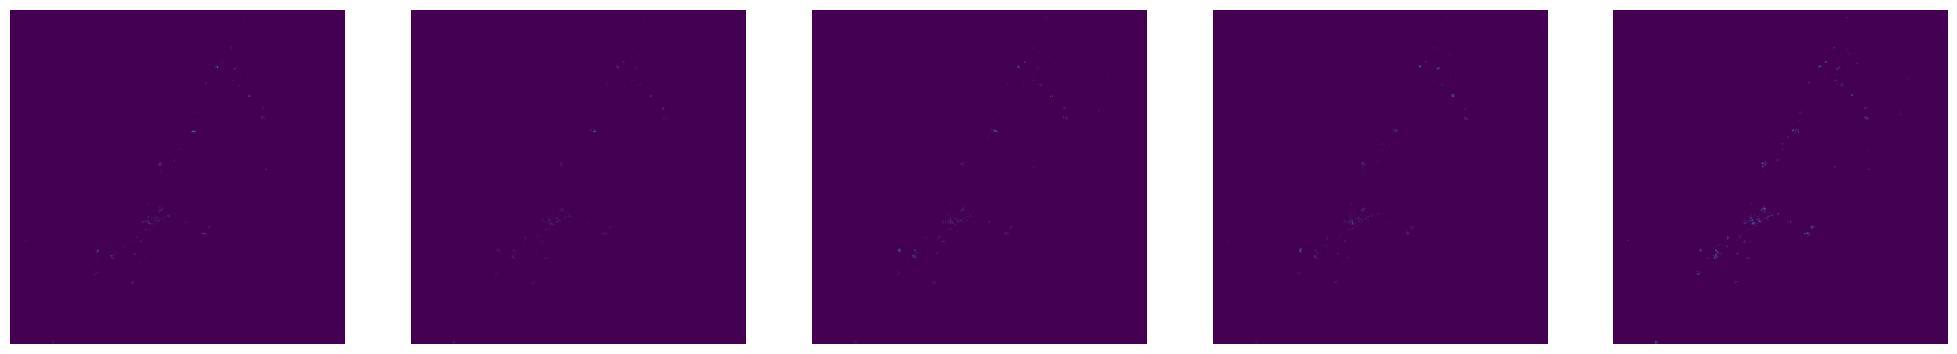

In [76]:
f, axs = plt.subplots(1, 5, figsize=(25, 5))

for i, idx in enumerate(range(0, 49, 10)):
    sample = gc[-1][idx].detach().cpu().numpy() #* input_t[-1][idx].detach().cpu().numpy()
    sample = (sample > 0) * sample
    sample /= np.max(sample)
    axs[i].imshow(sample)
    axs[i].axis("off")

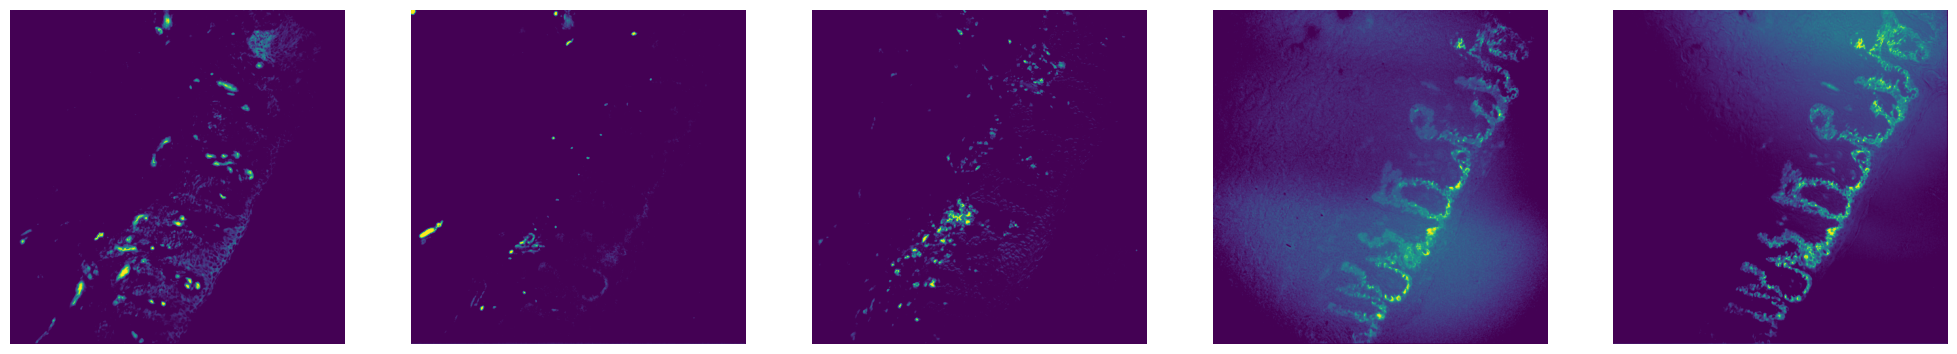

In [77]:
f, axs = plt.subplots(1, 5, figsize=(25, 5))

for i, idx in enumerate(range(0, 49, 10)):
    sample = input_t[-1][idx].detach().cpu().numpy() #* input_t[-1][idx].detach().cpu().numpy()
    sample = (sample > 0) * sample
    sample /= np.max(sample)
    axs[i].imshow(sample)
    axs[i].axis("off")

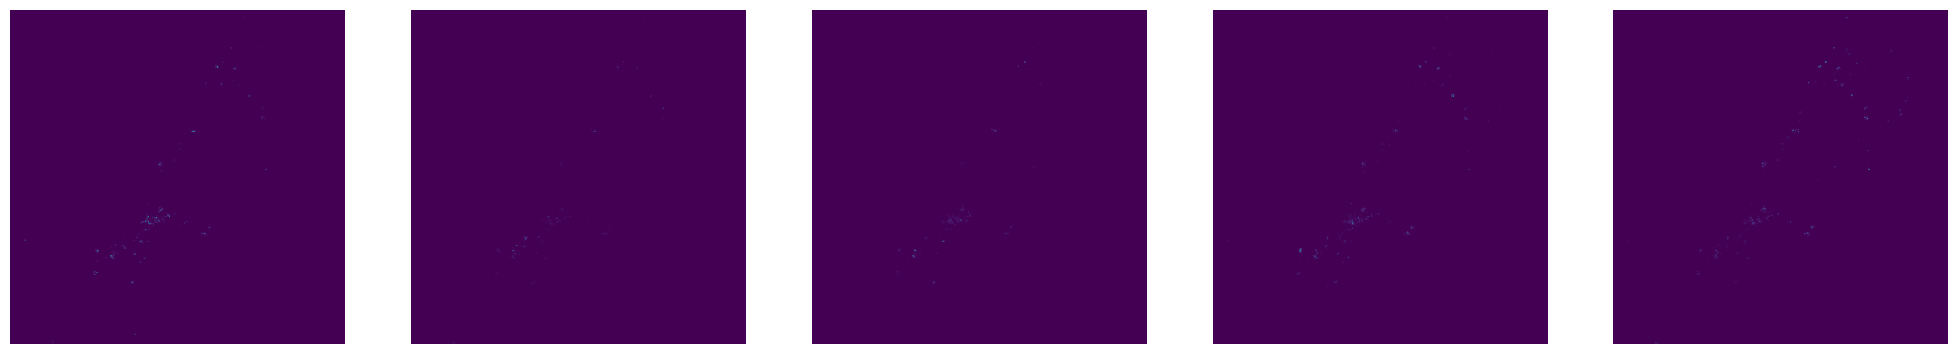

In [78]:
f, axs = plt.subplots(1, 5, figsize=(25, 5))

for i, idx in enumerate(range(0, 49, 10)):
    sample = gc[-1][idx].detach().cpu().numpy() * (input_t[-1][idx].detach().cpu().numpy() + np.abs(np.min(input_t[-1][idx].detach().cpu().numpy()))) #* input_t[-1][idx].detach().cpu().numpy()
    sample = (sample > 0) * sample
    sample /= np.max(sample)
    axs[i].imshow(sample)
    axs[i].axis("off")

In [62]:
ggc = GuidedGradCam(model.cuda(), model._modules["features"][-1], 0)

In [63]:
vdata = sorted([os.path.join(data, "validation", d) for d in os.listdir(os.path.join(data, "validation"))]) #+ [os.path.join(data, "training", d) for d in sorted(os.listdir(os.path.join(data, "training")))]) # balance_and_shuffle(os.path.join(data, "validation"))#
vdl = t.utils.data.DataLoader(MelanomaData(markers, vdata, mode="val"), batch_size=10) #, shuffle=True)
it = iter(vdl)

In [64]:
cams = list()
i=0
while True:
    print(i)
    i+=1
    try:
        input_t, label = next(it)
    except StopIteration:
        break
    gc = ggc.attribute(input_t.cuda(), attribute_to_layer_input=False)    
    cams.append(gc.detach().cpu().numpy())

0


/data/bionets/je30bery/anaconda3/envs/als_analysis/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/data/bionets/je30bery/anaconda3/envs/als_analysis/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


1
2
3
4


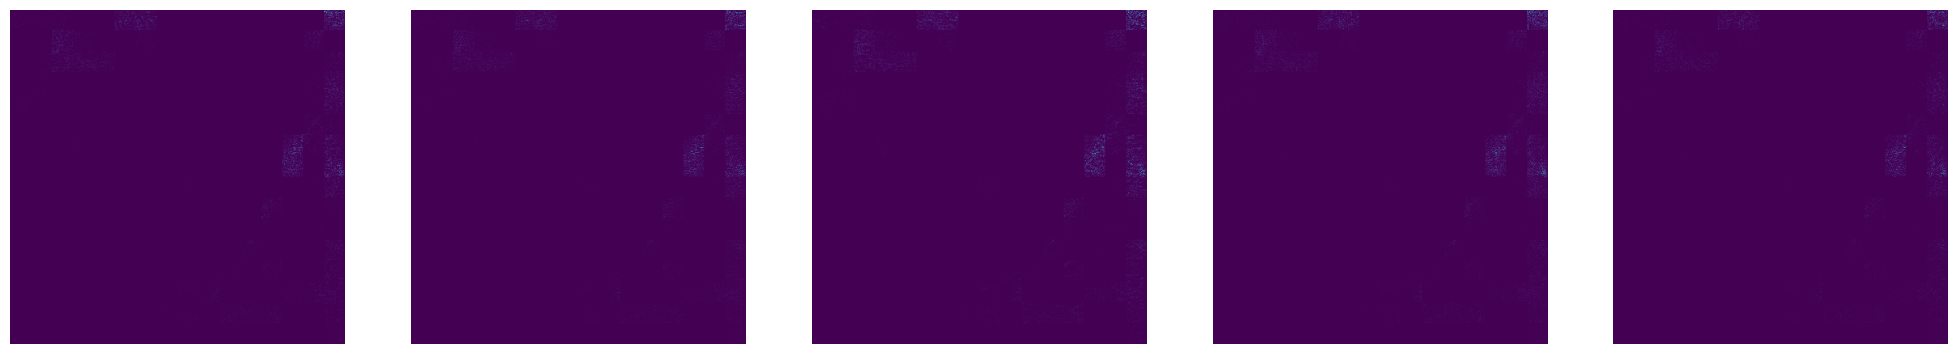

In [67]:
f, axs = plt.subplots(1, 5, figsize=(25, 5))

for i, idx in enumerate(range(0, 49, 10)):
    sample = gc[-1][idx].detach().cpu().numpy() #* input_t[-1][idx].detach().cpu().numpy()
    sample = (sample > 0) * sample
    sample /= np.max(sample)
    axs[i].imshow(sample)
    axs[i].axis("off")

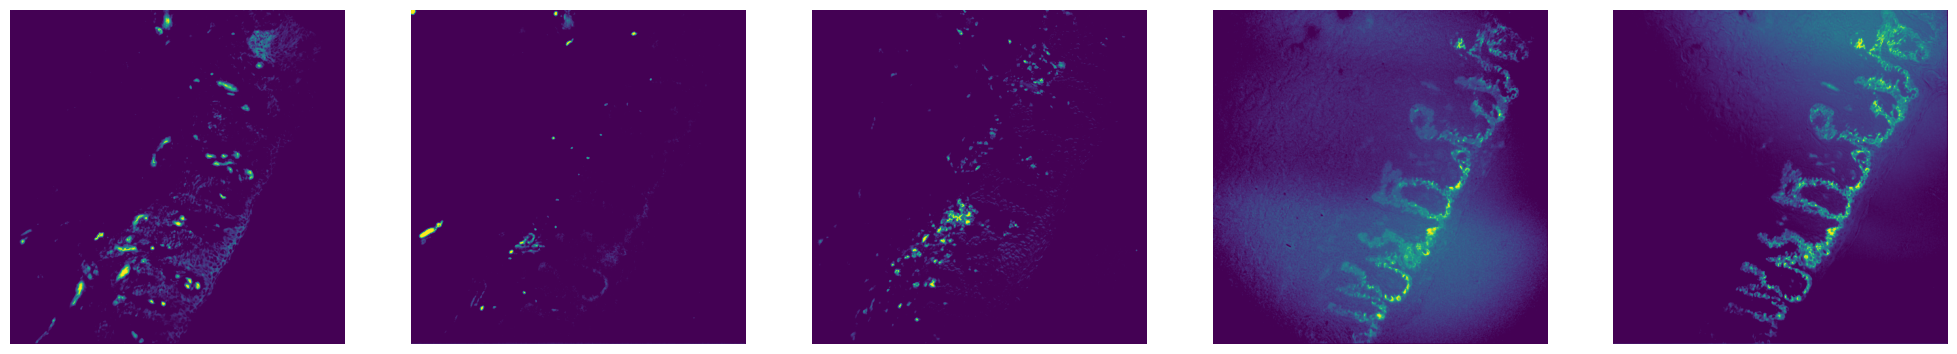

In [68]:
f, axs = plt.subplots(1, 5, figsize=(25, 5))

for i, idx in enumerate(range(0, 49, 10)):
    sample = input_t[-1][idx].detach().cpu().numpy() #* input_t[-1][idx].detach().cpu().numpy()
    sample = (sample > 0) * sample
    sample /= np.max(sample)
    axs[i].imshow(sample)
    axs[i].axis("off")

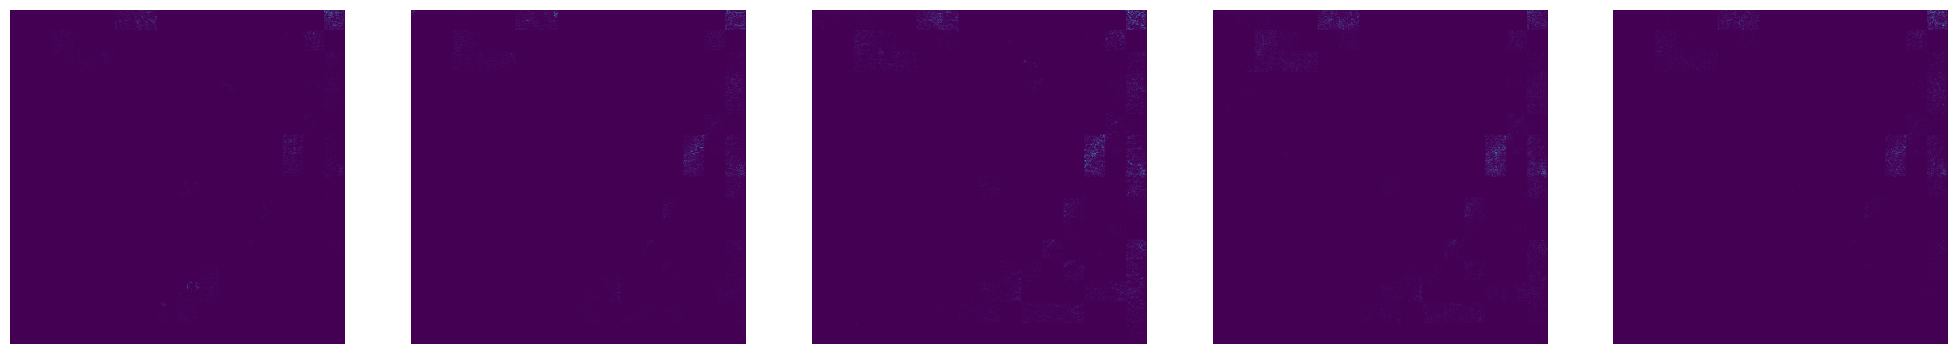

In [69]:
f, axs = plt.subplots(1, 5, figsize=(25, 5))

for i, idx in enumerate(range(0, 49, 10)):
    sample = gc[-1][idx].detach().cpu().numpy() * (input_t[-1][idx].detach().cpu().numpy() + np.abs(np.min(input_t[-1][idx].detach().cpu().numpy()))) #* input_t[-1][idx].detach().cpu().numpy()
    sample = (sample > 0) * sample
    sample /= np.max(sample)
    axs[i].imshow(sample)
    axs[i].axis("off")

In [82]:
markers = np.array(markers)
signi_markers = dict()
for i in range(len(cams)):
    test = cams[i]
    for j in range(test.shape[0]):
        sum = np.sum(test[j], axis=(1, 2))
        signi_markers[vdata[i*10+j]] = sum

In [83]:
df = pd.DataFrame(signi_markers, index=markers)
df.columns = [os.path.basename(c) for c in vdata]
df = df.reindex(sorted(df.columns), axis=1)
for c in df.columns:
    df[c] = df[c] / np.max(np.abs(df[c]))

<Axes: >

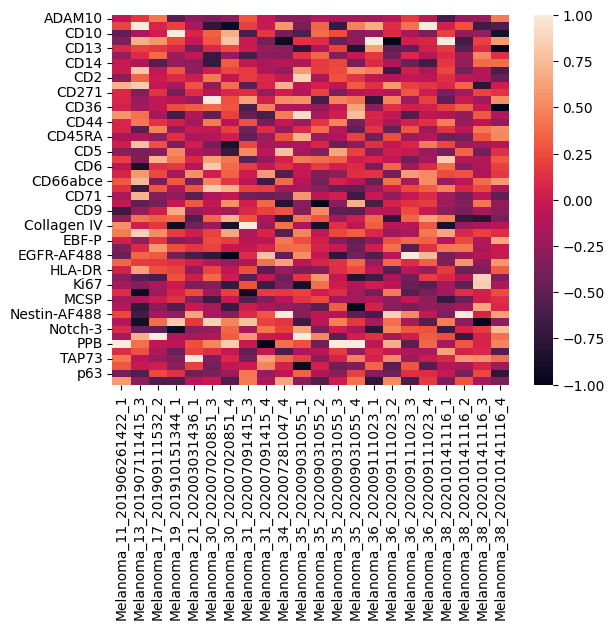

In [84]:
sns.heatmap(df[[c for c in df.columns if "Melanoma" in c]])

In [85]:
df["sum"] = df.sum(axis=1)

In [86]:
df.sort_values("sum", ascending=False)

,Melanoma_11_201906261422_1,Melanoma_13_201907111415_3,Melanoma_17_201909111532_2,Melanoma_19_201910151344_1,Melanoma_21_202003031436_1,Melanoma_30_202007020851_3,Melanoma_30_202007020851_4,Melanoma_31_202007091415_3,Melanoma_31_202007091415_4,Melanoma_34_202007281047_4,...,Nevi_11_201904251621_3,Nevi_11_201904251621_4,Nevi_12_201905161343_3,Nevi_13_201905241311_3,Nevi_13_201905241311_4,Nevi_15_201910021125_1,Nevi_15_201910021125_2,Nevi_15_201910021125_3,Nevi_15_201910021125_4,sum
PPB,1.000000,0.397438,-0.045748,-0.070334,0.269694,0.496306,0.828460,-0.014603,-1.000000,0.397547,...,0.357336,0.301557,0.345229,0.062055,0.184872,-0.403258,0.025524,-0.768885,-0.098645,7.337763
PPARgamma,-0.159173,0.690465,1.000000,-0.127864,-0.182799,-0.130899,0.327840,0.568415,-0.003884,-0.033021,...,0.114731,0.975917,-0.554484,0.928950,0.644156,-0.459053,1.000000,0.275457,0.802123,7.322845
TAP73,0.423067,-0.076566,-0.240766,-0.339284,1.000000,-0.361121,0.087743,-0.399297,0.630216,0.363658,...,0.005456,-0.331240,0.686724,0.435298,0.844116,-0.574290,-0.536241,-0.159556,-0.317825,6.721198
HLA-ABC,0.346790,0.186562,0.179653,0.133655,0.026166,-0.122021,-0.243528,-0.143684,0.400698,0.621476,...,0.094709,0.134283,0.297638,-0.445531,0.026218,0.312721,-0.635667,0.313603,0.265494,5.558496
CD56,0.195310,-0.347200,0.711521,0.427107,0.083720,0.623694,0.424854,-0.508855,-0.270568,0.054518,...,0.098082,0.607062,0.007231,0.330919,0.289506,-0.278883,-0.123318,0.526610,-0.168372,5.107498
CD25,0.715874,0.837546,-0.031823,-0.166451,0.288698,-0.279784,0.396905,-0.515610,0.077022,0.700919,...,0.225218,-0.001088,0.390175,0.184069,0.067071,-0.636357,0.309320,-0.171231,-0.311268,5.030907
Cytokeratin-14,0.452456,0.866668,0.530405,0.182068,0.027077,0.214758,0.644200,-0.129338,0.063947,-0.546693,...,0.486257,0.776295,-0.356598,0.255384,0.353254,-0.078270,-0.443121,-0.027579,0.085150,5.020307
CD66abce,0.298365,0.740773,-0.385022,0.297469,-0.401827,0.484743,0.151258,-0.091454,-0.685446,0.380077,...,0.418304,1.000000,-0.120435,-0.019503,-0.140874,-0.408225,0.463406,0.022285,1.000000,3.675318
CD4,0.563486,0.402937,-0.189593,-0.634716,-0.118703,-0.486082,0.197653,-0.490735,-0.607271,0.459220,...,0.408033,0.310088,0.882987,0.893181,0.344443,0.623433,0.001358,-0.613650,0.035761,3.639644
CD2,-0.310420,0.338592,-0.003576,0.103973,0.008445,0.439991,-0.057397,0.181377,0.082718,-0.015860,...,0.861137,-0.036337,0.195109,0.020395,0.203644,-0.461585,0.274868,0.051063,0.115899,3.395579


In [87]:
from sklearn.decomposition import PCA

In [88]:
pca = PCA(2)
res = pca.fit_transform(df.drop("sum", axis="columns").T)

In [89]:
labels = np.array([int("Nevi" in d) for d in sorted(vdata)])

In [90]:
sign, counts = np.unique(np.concatenate(list(signi_markers.values())), return_counts=True)

In [ ]:
count_sort_ind = np.argsort(-counts[np.where(counts>35)])
sign[np.where(counts>35)][count_sort_ind]

In [ ]:
counts[count_sort_ind]

In [ ]:
plt.imshow(cv2.imread("/data_nfs/datasets/melc/melanoma/processed/validation/Melanoma_36_202009111023_3/21100_TAP73-FITC_5000_068.tif", cv2.IMREAD_GRAYSCALE))

In [ ]:
import torch as t
#from pytorch_grad_cam import GradCAM
#from pytorch_grad_cam.utils.image import show_cam_on_image
#from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2 
from model import EfficientnetWithFinetuning
from data import MelanomaData
import os
import numpy as np
from melanoma_main import balance_and_shuffle
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
plt.style.use('dark_background')
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [ ]:
target_layers = [model.features[0]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

In [ ]:
if 0:
    h, w = 13, 3
    f, axs = plt.subplots(h, w, figsize=(15, 50))
    for idx in range(len(vdata)):
        axs[idx % h, int(idx / h)].imshow(visualizations[idx])
        title = os.path.basename(vdata[idx]) #"Melanoma" if labels[idx] == 0 else "Nevi"
        axs[idx % h, int(idx / h)].set_title(title)
        axs[idx % h, int(idx / h)].axis("off")
    plt.savefig("gradcam_val.pdf")
    plt.show()

In [ ]:
roi_data = {
    '202003251552_1': 20974,
    '202004091556_1': 20982,
    '202004091556_4': 20985,
    '202004221438_1': 20990,
    '202004221438_3': 20992,
    '202004221438_4': 20993,
    '202004301203_2': 20998,
    '202004301203_4': 21000,
    '202005071402_4': 21010,
    '202007020851_4': 21047,
    '202007211656_4': 21060,
    '202007281047_3': 21069,
    '202009031055_3': 21087,
    '202009111023_3': 21100,
    '202009181022_1': 21102,
    '202009181022_3': 21104,
    '202010211103_1': 21124,
    '202010211055_2': 21129,
}

In [ ]:
path_dict = dict()
for roi in roi_data:
    print(roi)
    path = [p for p in vdata if roi in p]
    print(path)
    assert len(path) == 1
    path = path[0]
    idx = vdata.index(path)
    roi_path = f"/data_nfs/je30bery/melanoma_data/ROI/{roi_data[roi]}MelanomaArea.tif"
    path_dict[idx] = roi_path 

In [ ]:
len(path_dict)

In [ ]:
f, axs = plt.subplots(3, 6, figsize=(18,9))
for i, k in enumerate(path_dict):
    boundaries = cv2.resize((cv2.imread(path_dict[k], cv2.IMREAD_GRAYSCALE) > 0).astype(np.uint8), (512,512))
    axs[int(i/6), i%6].imshow(mark_boundaries(visualizations[k], boundaries, color=(1,0,0)))
    axs[int(i/6), i%6].axis("off")
    axs[int(i/6), i%6].set_title(k)
plt.suptitle("GradCAM results with marked expert annotations")
plt.tight_layout()
plt.savefig("gradcam_val.pdf")

In [ ]:
grayscale_cam.shape